# MTG: Color Classifier

In [1]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For downloading the data
import requests

import json

# NLP

from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS

from wordcloud import WordCloud, get_single_color_func
from PIL import Image

# Splitting the data

from sklearn.model_selection import train_test_split

# Model Evaluation
from sklearn.metrics import classification_report

# Helper functions
from helper_functions import plot_distribution

# Table of Contents

1. [Introduction](#Introduction)
2. [Checking Distributions](#Checking-Distributions)
3. [Feature Engineering](#Feature-Engineering)
4. [NLP](#NLP)
5. [References](#References)

## Introduction

On August 5th, 1993, Wizards of the Coast released the first set of Magic: The Gathering, *Limited Edition Alpha*. This then unknown card game began with 295 cards. Today, it is one of the most popular trading card games, right up there with Yugioh and Pokemon TCG, with a cardbase exceeding 24,000 unique entries. 

In Magic, you the player are a 'planeswalker' (in layman terms, think of yourself as a spellcaster), your deck represents your spellbook, and the individual cards represent different spells. Each card contains a various bits of information: what your spell does, what it costs to cast it, the type of spell it is, et cetera. In this project, we will be looking at these features and fit them to a classification model, to determine our dependant: the color identity of the card.

### What do we mean by 'color identity'?

<div style="text-align: left; display: inline-block; margin-top: 1.5em;">
<img src="assets/fivecolors.jpg" style="height: 50px" >
</div>

There are 5 colors in MTG. We can also consider the absence of any color to be a 6th color identity. Cards with the same color identity will have similar themes, such as similar keywords. Cards can also be of multiple color identities. The aim of this project will be to train a model to recognize these patterns in the card's description, and other provided independants, to classify the card accordingly.

### The Dataset

I have obtained a dataset of all unique cards (up to July 8) from [MTGJSON.com](https://mtgjson.com).

In [2]:
# You can use the code below to use our locally saved version of AtomicCards.json instead
# with open('data/AtomicCards.json') as f:
#    atomic_json = json.load(f)

r = requests.get("https://mtgjson.com/api/v5/AtomicCards.json")
atomic_json = r.json()

print("Meta:", atomic_json['meta']) 
print("Unique Cards:", len(atomic_json['data'].keys()))

Meta: {'date': '2022-07-21', 'version': '5.2.0+20220721'}
Unique Cards: 24719


Each unique card is represented by a dictionary of key-value pairs. Which keys are present will vary from card to card. For example, if a card is not a creature, there will be no mention of toughness or power.

In [100]:
# Output the keys of a creature card
print(atomic_json['data']['Snapcaster Mage'][0].keys())

dict_keys(['colorIdentity', 'colors', 'convertedManaCost', 'edhrecRank', 'foreignData', 'identifiers', 'keywords', 'layout', 'legalities', 'manaCost', 'manaValue', 'name', 'power', 'printings', 'purchaseUrls', 'rulings', 'subtypes', 'supertypes', 'text', 'toughness', 'type', 'types'])


There are certainly a lot of features, but we will be using the following as our independants:

* `manaValue`
* `name`
* `text`
* `keywords`
* `power`
* `toughness`
* `power : toughness`
* `(power + toughness) : manaValue`
* `types`
* `subtypes`

While it won't be used in the dataframe, we will be looking at `legalities` key to eliminate cards that have never been legal in a Standard MTG format. These includes cards from 'Un-sets' (joke sets) which don't follow traditional MTG design principles. 

In [4]:
# Initialize dataframe

features = ["colors","manaValue","text", "power", 
            "toughness", "types", "subtypes"]

df_original = pd.DataFrame(columns=features)

atomic_data = atomic_json['data']

for card in atomic_data:
    
    try:
        legalities = atomic_data[card][0]['legalities']
        if legalities == {} : continue # Skip card if it is illegal in any format
    except KeyError:
        continue
            
    row = []    
    
    for feature in features:
        try:
            row.append(atomic_data[card][0][feature])
        except KeyError:
            row.append(None)
    
    if row[5][0] == 'Conspiracy':
        continue
        
    
    df_original.loc[card] = row


In [5]:
df_original.reset_index(inplace=True)
df_original.rename(columns = {'index': 'name'}, inplace=True)
display(df_original.head())

,name,colors,manaValue,text,power,toughness,types,subtypes
0,+2 Mace,[W],2.0,Equipped creature gets +2/+2.\nEquip {3} ({3}:...,None,None,[Artifact],[Equipment]
1,A Little Chat,[U],2.0,"Casualty 1 (As you cast this spell, you may sa...",None,None,[Instant],[]
2,A-Acererak the Archlich,[B],3.0,When Acererak the Archlich enters the battlefi...,5,5,[Creature],"[Zombie, Wizard]"
3,A-Alrund's Epiphany,[U],7.0,Take an extra turn after this one. If this spe...,None,None,[Sorcery],[]
4,"A-Alrund, God of the Cosmos // A-Hakka, Whispe...",[U],5.0,Alrund gets +1/+1 for each card in your hand a...,1,1,[Creature],[God]


Some data processing needs to be done here:


### Handling NaN values

In [6]:
df_original.isna().sum()

name             0
colors           0
manaValue        0
text           334
power        10751
toughness    10751
types            0
subtypes         0
dtype: int64

#### text

Some cards, usually creature cards, don't have any text associated with them. We will simply replace the NaN value with an empty string.

#### power & toughness

Non-creature cards typically do not have power or toughness. We will be using the value -1 to designate cards without power/toughness.


In [7]:
# handling text
df_original['text'] = df_original['text'].fillna('')

# handling power & toughness
df_original['power'] = df_original['power'].fillna(-1)
df_original['toughness'] = df_original['toughness'].fillna(-1)

df_original.head()

,name,colors,manaValue,text,power,toughness,types,subtypes
0,+2 Mace,[W],2.0,Equipped creature gets +2/+2.\nEquip {3} ({3}:...,-1,-1,[Artifact],[Equipment]
1,A Little Chat,[U],2.0,"Casualty 1 (As you cast this spell, you may sa...",-1,-1,[Instant],[]
2,A-Acererak the Archlich,[B],3.0,When Acererak the Archlich enters the battlefi...,5,5,[Creature],"[Zombie, Wizard]"
3,A-Alrund's Epiphany,[U],7.0,Take an extra turn after this one. If this spe...,-1,-1,[Sorcery],[]
4,"A-Alrund, God of the Cosmos // A-Hakka, Whispe...",[U],5.0,Alrund gets +1/+1 for each card in your hand a...,1,1,[Creature],[God]


In [8]:
df_original.isna().sum()

name         0
colors       0
manaValue    0
text         0
power        0
toughness    0
types        0
subtypes     0
dtype: int64

The columns `colors`, `types` and `subtypes` are currently stored as lists, but ideally we don't want to work with lists when exploring/modelling our data later on. We will simply merge the lists into one string.

In [9]:
df_original['colors'] = df_original['colors'].apply(lambda x: ''.join(sorted(x)))
df_original['types'] = df_original['types'].apply(lambda x: ' '.join(sorted(x)))
df_original['subtypes'] = df_original['subtypes'].apply(lambda x: ' '.join(sorted(x)))

df_original.head()

,name,colors,manaValue,text,power,toughness,types,subtypes
0,+2 Mace,W,2.0,Equipped creature gets +2/+2.\nEquip {3} ({3}:...,-1,-1,Artifact,Equipment
1,A Little Chat,U,2.0,"Casualty 1 (As you cast this spell, you may sa...",-1,-1,Instant,
2,A-Acererak the Archlich,B,3.0,When Acererak the Archlich enters the battlefi...,5,5,Creature,Wizard Zombie
3,A-Alrund's Epiphany,U,7.0,Take an extra turn after this one. If this spe...,-1,-1,Sorcery,
4,"A-Alrund, God of the Cosmos // A-Hakka, Whispe...",U,5.0,Alrund gets +1/+1 for each card in your hand a...,1,1,Creature,God


For reasons we will explain further below, it will be helpful for us to temporarily treat the `power` and `toughness` columns as a string. We will convert them back to numbers later on.

In [10]:
df_original['power'] = df_original['power'].astype(str)
df_original['toughness'] = df_original['toughness'].astype(str)

## Checking Distributions

### `colors` distribution

First we will be looking at the distribution of our target class:

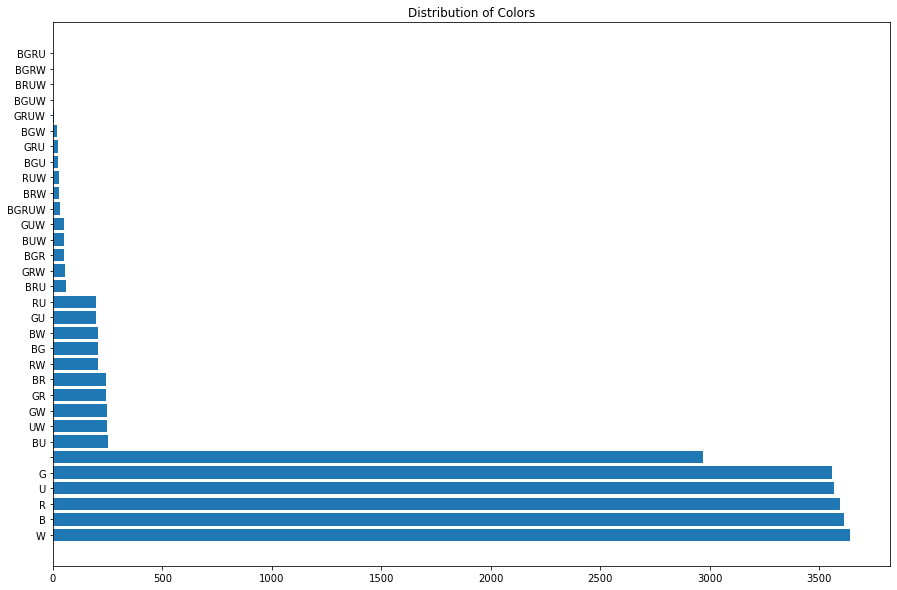

In [11]:
# Check for color distribution

plot_distribution(df_original,"colors",figsize=(15,10),title='Distribution of Colors')

We will end up with 7 classes: 5 representing the base colors (G,U,R,B,W), one for colorless cards, and one for multicolored cards.

0. Colorless,
1. Green,
2. Blue,
3. Red,
4. Black,
5. White,
6. Multicolored

### `types` distribution

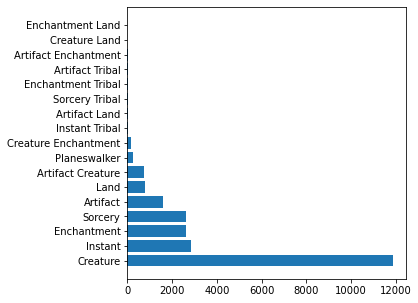

In [12]:
plot_distribution(df_original,'types')

### `power` and `toughness` distribution

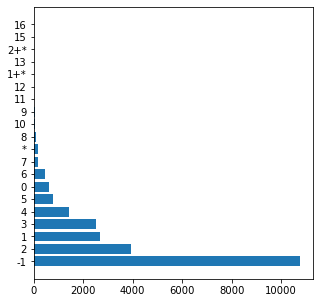

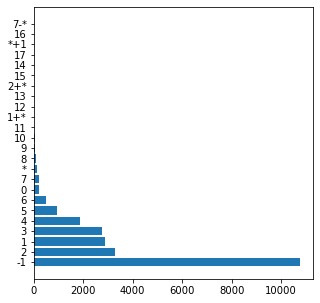

In [13]:
plot_distribution(df_original,'power')
plot_distribution(df_original,'toughness')

For some cards, there is an asterisk symbol in the power and toughness areas (see cards like Tarmogoyf). To prepare our data for the model, we will be substituting any card containing an asterisk with the manavalue of the card.

The reasoning behind doing this is from my domain knowledge the power (and toughness) of MTG cards is roughly connected to the manavalue of a card.

## Feature Engineering

- Reducing our dependant, `colors`, to 7 classes as described above.
- Removing asterisks from our `power` and `toughness` columns.

In [14]:
df_modified = df_original.copy()

df_modified['name_text'] = df_modified['name'] + ' ' + df_modified['text']
df_modified['name_text'] = df_modified['name_text'].apply(lambda x: x.replace('\n',' ')) 

df_modified.drop(columns=['text'], inplace=True)
df_modified.set_index('name', inplace=True)

df_modified.head()

,colors,manaValue,power,toughness,types,subtypes,name_text
name,,,,,,,
+2 Mace,W,2.0,-1,-1,Artifact,Equipment,+2 Mace Equipped creature gets +2/+2. Equip {3...
A Little Chat,U,2.0,-1,-1,Instant,,A Little Chat Casualty 1 (As you cast this spe...
A-Acererak the Archlich,B,3.0,5,5,Creature,Wizard Zombie,A-Acererak the Archlich When Acererak the Arch...
A-Alrund's Epiphany,U,7.0,-1,-1,Sorcery,,A-Alrund's Epiphany Take an extra turn after t...
"A-Alrund, God of the Cosmos // A-Hakka, Whispering Raven",U,5.0,1,1,Creature,God,"A-Alrund, God of the Cosmos // A-Hakka, Whispe..."


In [15]:
df_modified.loc[df_modified['power'].str.contains('\*'), 'power'] = df_modified[df_modified['power'].str.contains('\*')]['manaValue'].astype(int)

df_modified.loc[df_modified['toughness'].str.contains('\*'), 'toughness'] = df_modified[df_modified['toughness'].str.contains('\*')]['manaValue'].astype(int)


In [16]:
df_modified['power'] = df_modified['power'].astype(int)
df_modified['toughness'] = df_modified['toughness'].astype(int)

df_modified.head()

,colors,manaValue,power,toughness,types,subtypes,name_text
name,,,,,,,
+2 Mace,W,2.0,-1,-1,Artifact,Equipment,+2 Mace Equipped creature gets +2/+2. Equip {3...
A Little Chat,U,2.0,-1,-1,Instant,,A Little Chat Casualty 1 (As you cast this spe...
A-Acererak the Archlich,B,3.0,5,5,Creature,Wizard Zombie,A-Acererak the Archlich When Acererak the Arch...
A-Alrund's Epiphany,U,7.0,-1,-1,Sorcery,,A-Alrund's Epiphany Take an extra turn after t...
"A-Alrund, God of the Cosmos // A-Hakka, Whispering Raven",U,5.0,1,1,Creature,God,"A-Alrund, God of the Cosmos // A-Hakka, Whispe..."


In [17]:
color_map = {'': 0, 'G': 1, 'U': 2, 'R': 3, 'B': 4, 'W': 5}
    
df_modified['colors'] = df_modified['colors'].apply(lambda x: color_map.get(x, 6))

df_modified.head()

,colors,manaValue,power,toughness,types,subtypes,name_text
name,,,,,,,
+2 Mace,5,2.0,-1,-1,Artifact,Equipment,+2 Mace Equipped creature gets +2/+2. Equip {3...
A Little Chat,2,2.0,-1,-1,Instant,,A Little Chat Casualty 1 (As you cast this spe...
A-Acererak the Archlich,4,3.0,5,5,Creature,Wizard Zombie,A-Acererak the Archlich When Acererak the Arch...
A-Alrund's Epiphany,2,7.0,-1,-1,Sorcery,,A-Alrund's Epiphany Take an extra turn after t...
"A-Alrund, God of the Cosmos // A-Hakka, Whispering Raven",2,5.0,1,1,Creature,God,"A-Alrund, God of the Cosmos // A-Hakka, Whispe..."


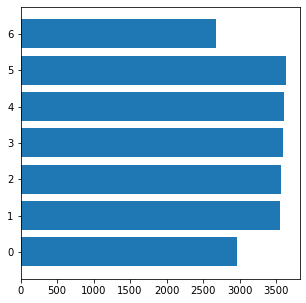

In [18]:
# Check for new color distribution

plot_distribution(df_modified, 'colors')

## NLP

We now have our modified dataset.

In [19]:
df_modified.head()

,colors,manaValue,power,toughness,types,subtypes,name_text
name,,,,,,,
+2 Mace,5,2.0,-1,-1,Artifact,Equipment,+2 Mace Equipped creature gets +2/+2. Equip {3...
A Little Chat,2,2.0,-1,-1,Instant,,A Little Chat Casualty 1 (As you cast this spe...
A-Acererak the Archlich,4,3.0,5,5,Creature,Wizard Zombie,A-Acererak the Archlich When Acererak the Arch...
A-Alrund's Epiphany,2,7.0,-1,-1,Sorcery,,A-Alrund's Epiphany Take an extra turn after t...
"A-Alrund, God of the Cosmos // A-Hakka, Whispering Raven",2,5.0,1,1,Creature,God,"A-Alrund, God of the Cosmos // A-Hakka, Whispe..."


In [20]:
# 1. Instantiate 
bagofwords = CountVectorizer(stop_words='english',
                             ngram_range=(1, 5)
                             ,min_df=5, token_pattern=r"(?u)\b\w\w+\b|\+1/\+1|\-1/\-1")

# 2. Fit 
bagofwords.fit(df_modified['name_text'])

# 3. Transformed
all_cards_counts = bagofwords.transform(df_modified['name_text'])


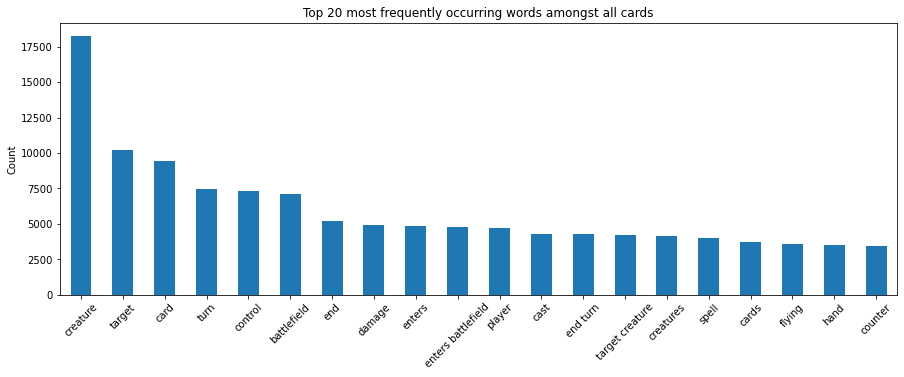

In [21]:
wc_df = pd.DataFrame(
        {"counts": all_cards_counts.toarray().sum(axis=0)},
        index=bagofwords.get_feature_names()
    ).sort_values("counts", ascending=False)

wc_df.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title(f"Top 20 most frequently occurring words amongst all cards")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

Based on my own domain of MTG, and as you can see above, there are certain words that can easily appear across all cards with high frequency (creature, target, battlefield, etc.) that have little influence on the color identity of the card.

In [22]:
f = open("data/mtg_stopwords.txt","r")
mtg_stopwords = f.read().splitlines()

custom_stop_words = ENGLISH_STOP_WORDS.union(mtg_stopwords)

In [23]:
# 1. Instantiate 
bagofwords = CountVectorizer(stop_words=custom_stop_words,
                             ngram_range=(1, 5),
                             min_df=5,
                             token_pattern=r"(?u)\b\w\w+\b|\+1/\+1|\-1/\-1")

# 2. Fit 
bagofwords.fit(df_modified['name_text'])

# 3. Transform

word_counts = []

for c in range(7):
    transformed = bagofwords.transform(df_modified[df_modified['colors'] == c]['name_text'])
    word_counts.append(transformed)

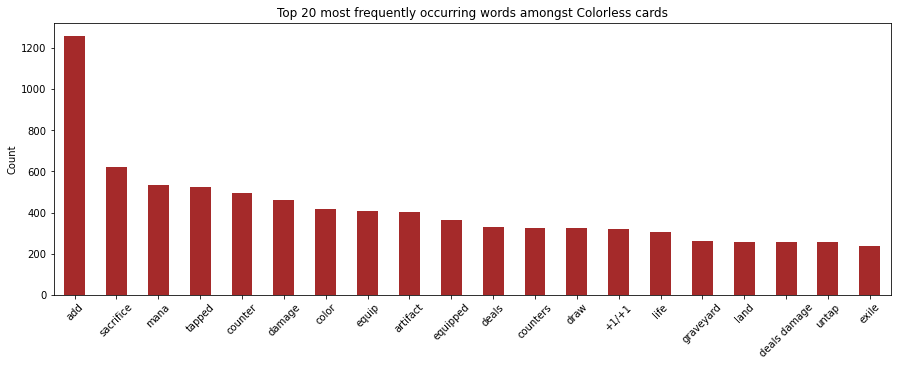

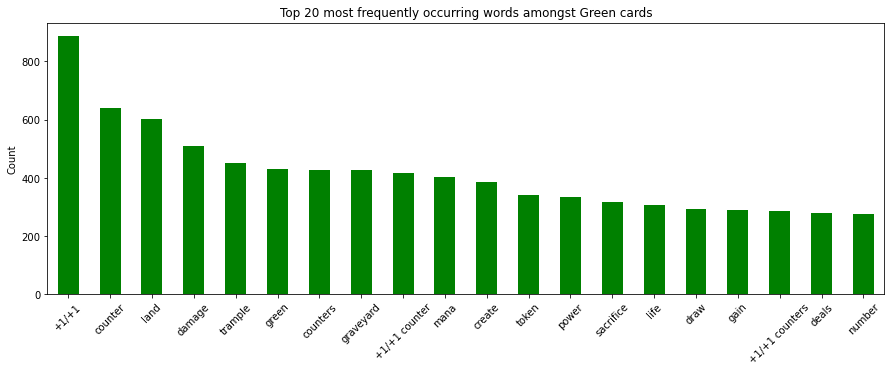

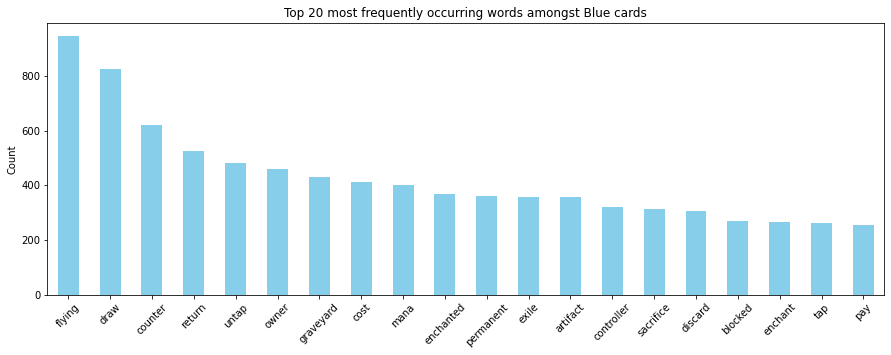

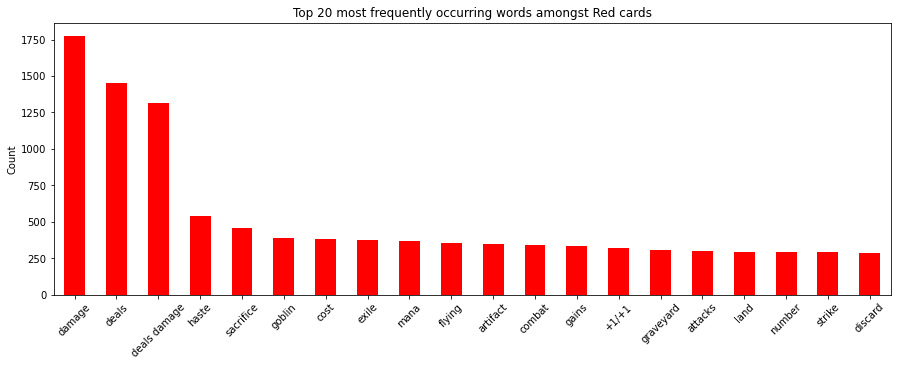

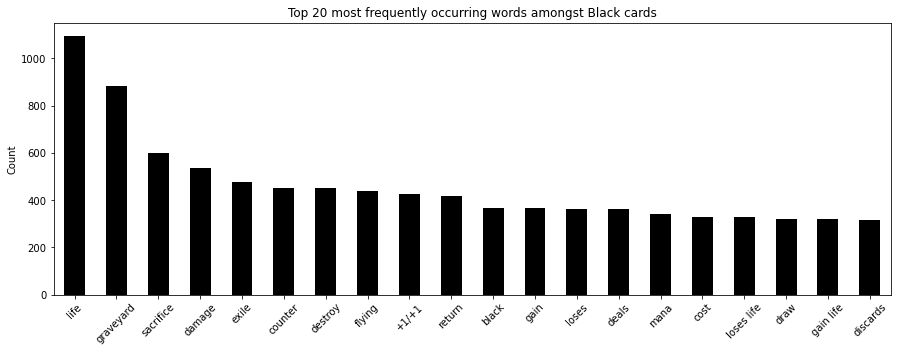

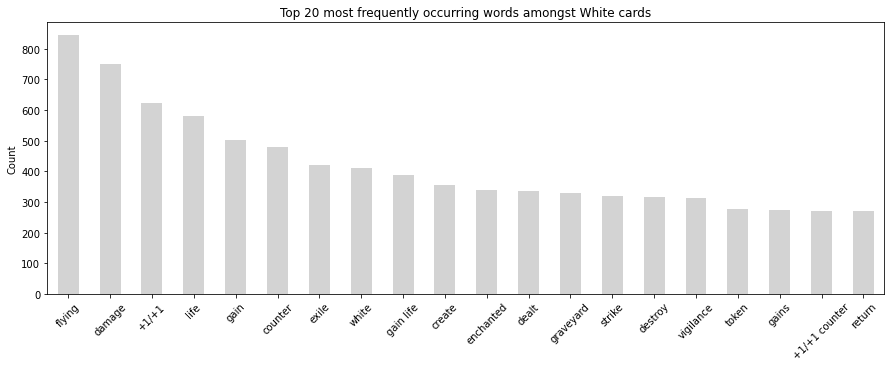

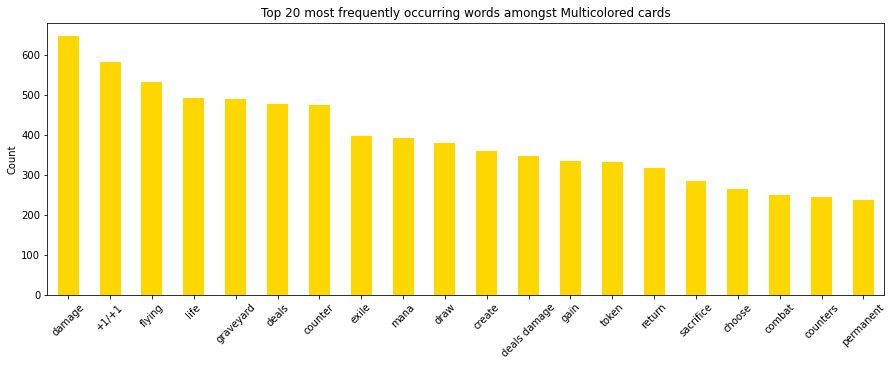

In [24]:
target_classes = ['Colorless','Green','Blue','Red','Black','White','Multicolored']
color_codes = ['brown','green','skyblue','red','black','lightgray','gold']

frequency_dfs = []

for c in range(7):
    
    wc_df = pd.DataFrame(
        {"counts": word_counts[c].toarray().sum(axis=0)},
        index=bagofwords.get_feature_names()
    ).sort_values("counts", ascending=False)

    wc_df.head(20).plot(kind="bar", figsize=(15, 5), legend=False, color=color_codes[c] )
    plt.title(f"Top 20 most frequently occurring words amongst {target_classes[c]} cards")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.savefig(f'visualizations/{target_classes[c]}_frequent_words.png', bbox_inches='tight', dpi=300)
    plt.show()
    
    frequency_dfs.append(wc_df)

For better visualization, I will be using the WordCloud library:

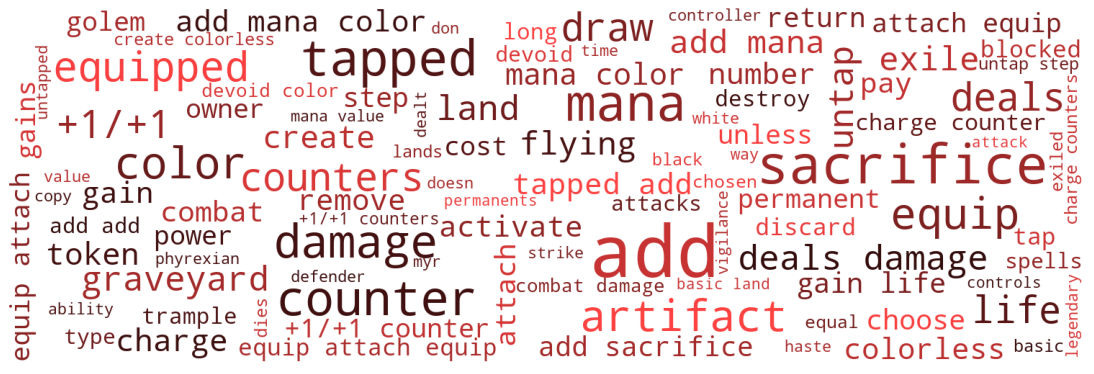

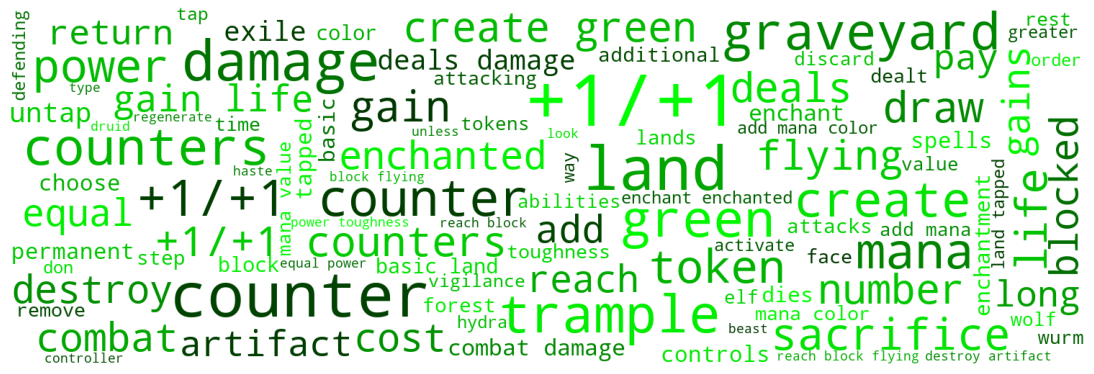

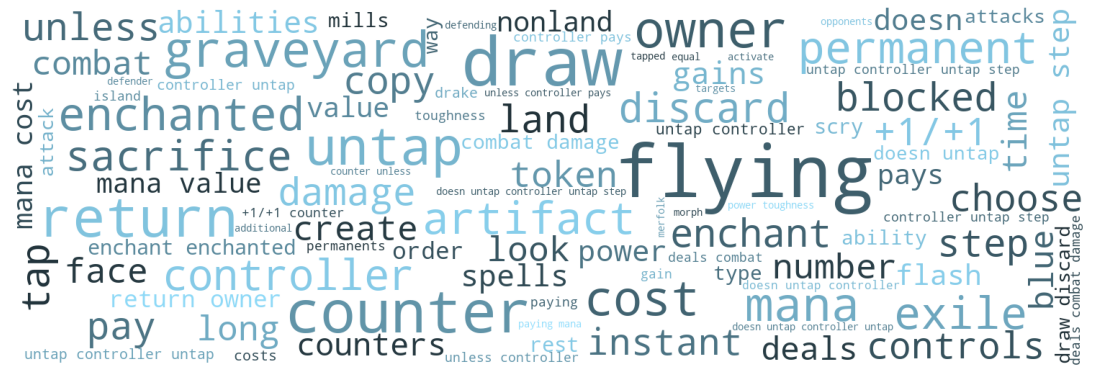

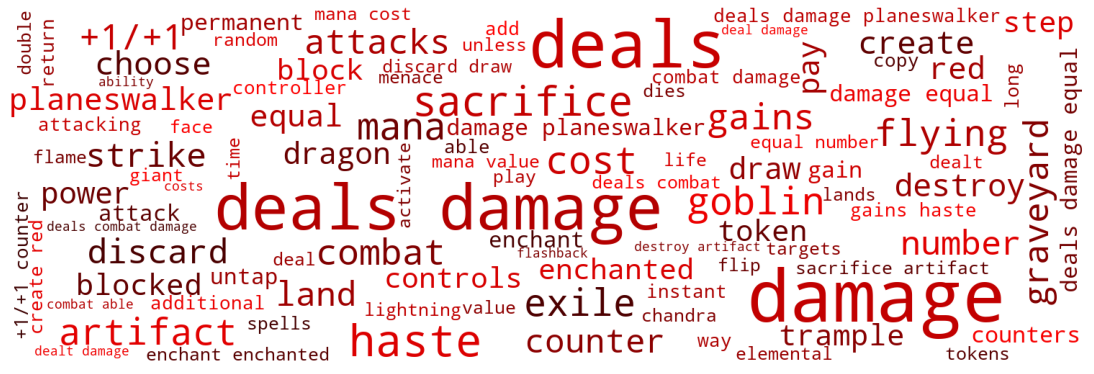

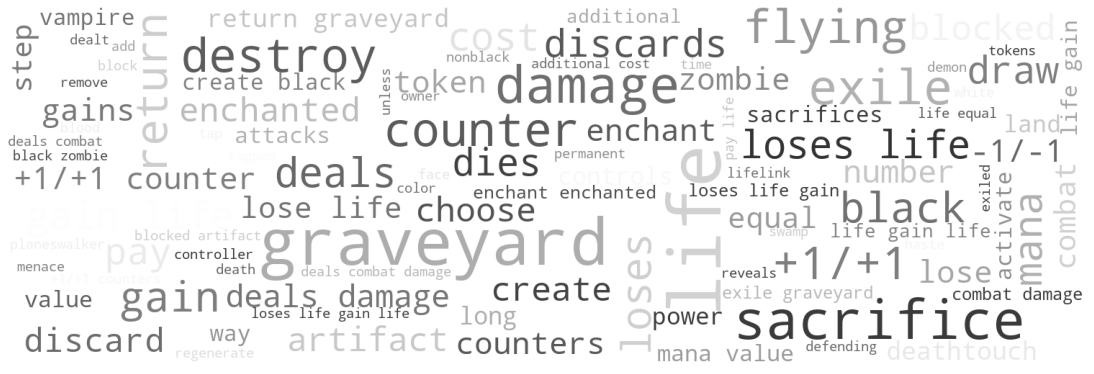

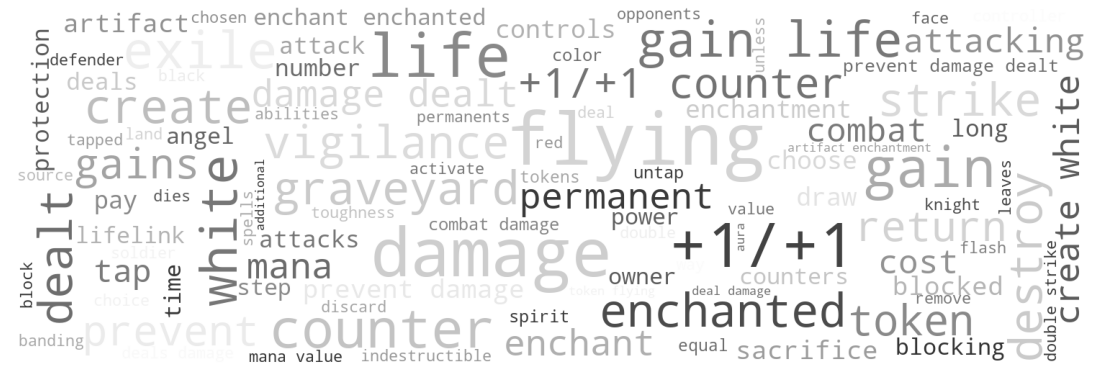

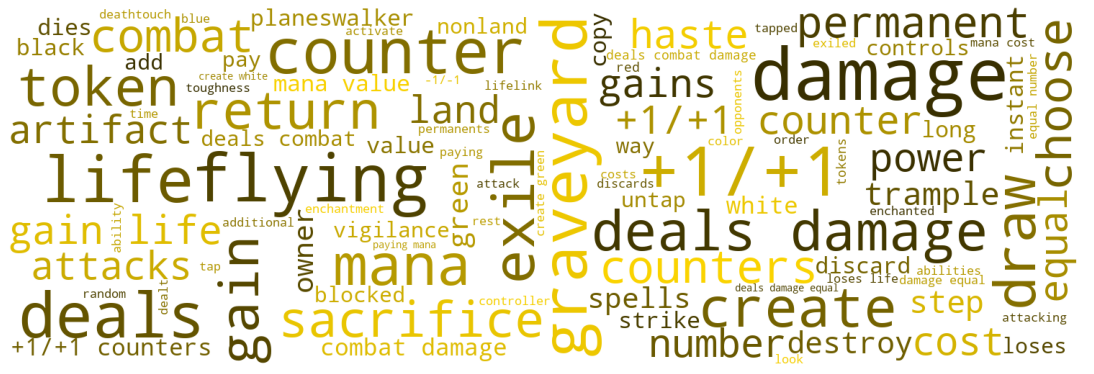

In [25]:

for i in range(7):

    data = dict(zip(frequency_dfs[i].index.tolist(), frequency_dfs[i]['counts'].tolist()))
    
    wc = WordCloud(width=1500, height=500, max_words=100, max_font_size=100, 
                   background_color='white').generate_from_frequencies(data)
 
    # generate color function
    color_func = get_single_color_func(color_codes[i])

    # plot the WordCloud image                      
    plt.figure(figsize=(15,5))
    plt.imshow(wc.recolor(color_func=color_func))
    plt.axis("off")
    
    plt.tight_layout(pad = 0)

    plt.show()
    
    wc.to_file(f'visualizations/{target_classes[i]}_wordcloud.png')

## Preparing For Modeling

In [26]:
X = df_modified.drop(columns='colors')
y = df_modified['colors']

In [27]:
# Dummify the types + subtypes column

X = pd.get_dummies(X,columns=['types'])
X = pd.get_dummies(X,columns=['subtypes'])


It's import we split the data into the test-train split at this juncture, before vectorizing our data. The reason for this is we should not be exposing our model to our test set.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1337)

In [29]:
# 1. Instantiate 
bagofwords = CountVectorizer(stop_words=custom_stop_words
                             ,ngram_range=(1, 5)
                             ,min_df=5
                             ,token_pattern=r"(?u)\b\w\w+\b|\+1/\+1|\-1/\-1")

# 2. Fit 
bagofwords.fit(X_train['name_text'])

# 3. Transform

name_text_transformed = bagofwords.transform(X_train['name_text'])

column_names = [('text_' + x) for x in bagofwords.get_feature_names()]

sparse_df = pd.DataFrame.sparse.from_spmatrix(name_text_transformed, columns=column_names, )
sparse_df['name'] = X_train.index
sparse_df.set_index('name', inplace=True)

In [30]:

X_train_vectorized = pd.concat([X_train, sparse_df], axis=1)
X_train_vectorized.drop(columns='name_text',inplace=True)

X_train_vectorized.head()

,manaValue,power,toughness,types_Artifact,types_Artifact Creature,types_Artifact Enchantment,types_Artifact Land,types_Artifact Tribal,types_Creature,types_Creature Enchantment,...,text_zombie token decayed,text_zombie token decayed block,text_zombie token decayed block attacks,text_zombie tokens,text_zombies,text_zombies +1/+1,text_zone,text_zone game,text_zubera,text_zubera dies
name,,,,,,,,,,,,,,,,,,,,,
Mosquito Guard,1.0,1,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
Serene Remembrance,1.0,-1,-1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Dance of Shadows,5.0,-1,-1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ritual of Steel,3.0,-1,-1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Knights of the Black Rose,5.0,4,4,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
from sklearn.linear_model import LogisticRegression

# 1. Instantiate model
credit_logit = LogisticRegression(solver='lbfgs', random_state=1, max_iter=10000)

# 2. Fit model
credit_logit.fit(X_train_vectorized, y_train);


/Users/raywinardi/opt/anaconda3/envs/deeplearning/lib/python3.8/site-packages/sklearn/utils/validation.py:515: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [32]:
# Transform the test data based on the vectorizer fitted on the train data

name_text_transformed = bagofwords.transform(X_test['name_text'])

column_names = [('text_' + x) for x in bagofwords.get_feature_names()]

sparse_df = pd.DataFrame.sparse.from_spmatrix(name_text_transformed, columns=column_names)
sparse_df['name'] = X_test.index
sparse_df.set_index('name', inplace=True)

In [33]:
X_test_vectorized = pd.concat([X_test, sparse_df], axis=1)
X_test_vectorized.drop(columns='name_text',inplace=True)



In [101]:
print("Train Score: ",credit_logit.score(X_train_vectorized, y_train))
print("Test Score: ",credit_logit.score(X_test_vectorized, y_test))

/Users/raywinardi/opt/anaconda3/envs/deeplearning/lib/python3.8/site-packages/sklearn/utils/validation.py:515: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Train Score:  0.9327324420785191


/Users/raywinardi/opt/anaconda3/envs/deeplearning/lib/python3.8/site-packages/sklearn/utils/validation.py:515: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Test Score:  0.707874682472481


In [102]:
y_pred = credit_logit.predict(X_test_vectorized) 

report_initial = classification_report(y_test, y_pred)
print(report_initial)

/Users/raywinardi/opt/anaconda3/envs/deeplearning/lib/python3.8/site-packages/sklearn/utils/validation.py:515: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.90      0.95      0.93       861
           1       0.69      0.69      0.69      1085
           2       0.71      0.77      0.74      1109
           3       0.73      0.73      0.73      1099
           4       0.73      0.72      0.72      1097
           5       0.66      0.71      0.68      1033
           6       0.44      0.33      0.38       802

    accuracy                           0.71      7086
   macro avg       0.70      0.70      0.70      7086
weighted avg       0.70      0.71      0.70      7086



In [119]:
probabilities_df = pd.DataFrame(credit_logit.predict_proba(X_test_vectorized)
                                , columns=credit_logit.classes_
                                , index=X_test_vectorized.index) 

probabilities_df['Actual Class'] = y_test
probabilities_df.sample(n = 5)

/Users/raywinardi/opt/anaconda3/envs/deeplearning/lib/python3.8/site-packages/sklearn/utils/validation.py:515: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


,0,1,2,3,4,5,6,Actual Class
name,,,,,,,,
Galvanic Iteration,0.005995,0.024483,0.309813,0.051763,0.001832,0.003940,0.602174,6
Threnody Singer,0.000029,0.000426,0.981567,0.000720,0.000451,0.016196,0.000611,2
Master the Way,0.004506,0.213914,0.052516,0.064035,0.045558,0.325960,0.293511,6
Devastate,0.002286,0.008911,0.001119,0.920076,0.031460,0.002551,0.033598,3
Plague Witch,0.000063,0.000878,0.000829,0.003168,0.984201,0.000288,0.010573,4


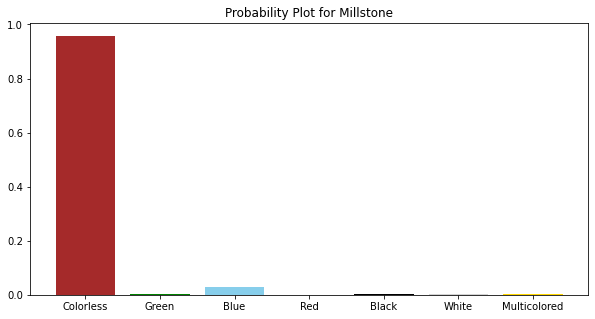

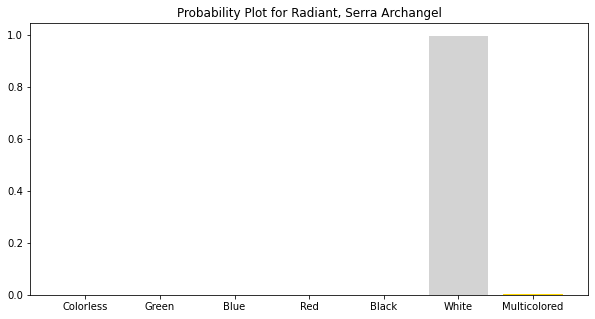

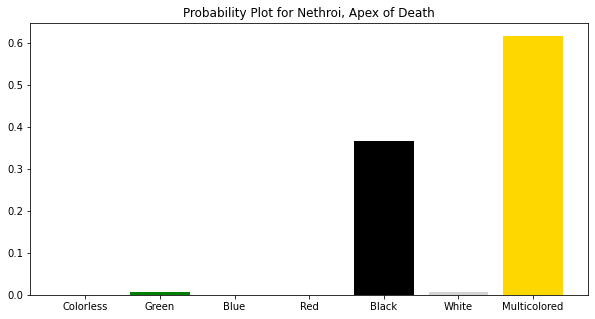

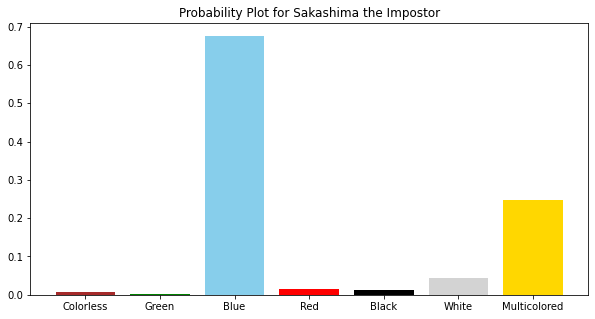

In [117]:
def plot_probabilities(df, name):
    temp = df[df.index == name]
    
    plt.figure(figsize=(10,5))
    
    for i in range(7):
        plt.bar(target_classes[i],temp[i],color=color_codes[i])
    
    plt.title(f'Probability Plot for {name}')
    plt.savefig(f'visualizations/probplots/{name}.png', bbox_inches='tight', dpi=300)
    
    plt.show()
    
# Cards the model got right
plot_probabilities(probabilities_df, 'Millstone')
plot_probabilities(probabilities_df, 'Radiant, Serra Archangel')
plot_probabilities(probabilities_df, 'Nethroi, Apex of Death')
plot_probabilities(probabilities_df, 'Sakashima the Impostor')

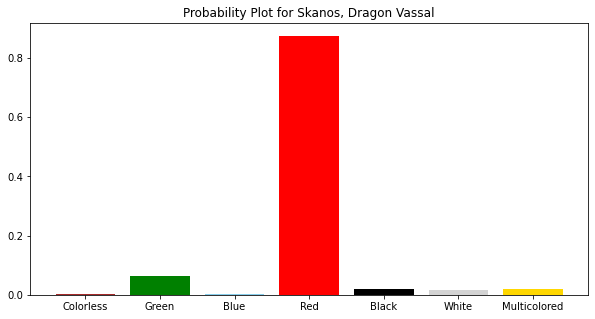

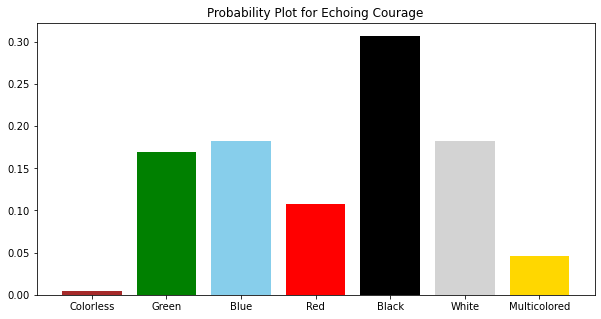

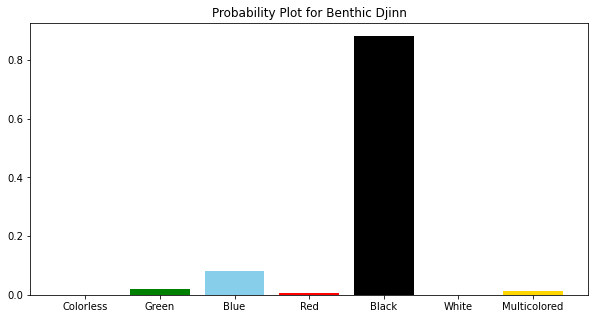

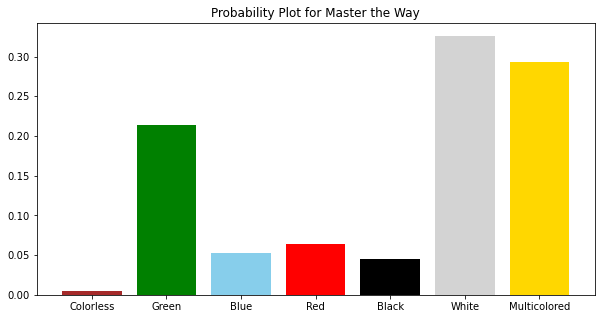

In [120]:
# Cards we got wrong

plot_probabilities(probabilities_df, 'Skanos, Dragon Vassal')
plot_probabilities(probabilities_df, 'Echoing Courage')
plot_probabilities(probabilities_df, 'Benthic Djinn')
plot_probabilities(probabilities_df, 'Master the Way')

## Initial Takeaways

- Our model is excellent at identifying colorless cards.
- Our model has terrible performance at correctly identifying multicolored cards.

## References

Inspired by the repository [MTG Color Classifier](https://github.com/Yee-Brian21/MTG-Color-Classifier) by Github user [Yee-Brian21](https://github.com/Yee-Brian21).

Credit to the following StackOverflows posts for:

- Figuring out how to convert a dataframe to be used with WordCloud:
    - https://stackoverflow.com/questions/57826063/how-to-create-a-wordcloud-according-to-frequencies-in-a-pandas-dataframe